In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

data_dir = './DATA/'
SEED = 123

## Load the dataset

In [3]:
df_bcell = pd.read_csv(data_dir+'input_bcell.csv')
df_sars = pd.read_csv(data_dir+'input_sars.csv')
df = pd.concat([df_bcell, df_sars], ignore_index=True)
df.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1


## Preprocessing

In [4]:
# feature columns
feature_cols = [col for col in df.columns if col not in ['parent_protein_id', 'protein_seq', 'peptide_seq', 'target']]
print(feature_cols)

# split df into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df.target, test_size=0.2, random_state=SEED)
y_train = y_train.to_frame()
y_test = y_test.to_frame()

# normalization
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=feature_cols)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

['start_position', 'end_position', 'chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 'isoelectric_point', 'aromaticity', 'hydrophobicity', 'stability']


In [4]:
print(df[df.target==0].shape[0])
print(df[df.target==1].shape[0])

10865
4042


In [7]:
def train_model(model, X_train=X_train, y_train=y_train, nfold=7):
    skf = StratifiedKFold(n_splits = nfold, shuffle=True, random_state = SEED)

    train_loss, val_loss, test_loss = [], [],[]
    train_accu, val_accu, test_accu = [], [], []
    train_prec, val_prec, test_prec = [], [], []
    train_recall, val_recall, test_recall = [], [], []
    train_f1, val_f1, test_f1 = [], [], []
    test_confusion = np.zeros((2,2))
    for train_index, val_index in skf.split(X_train, y_train):
        train, val = X_train.iloc[train_index], X_train.iloc[val_index]
        train_targets, val_targets = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(train, train_targets)

        train_pred_proba = model.predict_proba(train)
        val_pred_proba = model.predict_proba(val)
        test_pred_proba = model.predict_proba(X_test)
        # neg log loss
        train_loss.append(log_loss(train_targets, train_pred_proba))
        val_loss.append(log_loss(val_targets, val_pred_proba))
        test_loss.append(log_loss(y_test, test_pred_proba))

        train_pred = model.predict(train)
        val_pred = model.predict(val)
        test_pred = model.predict(X_test)
        # accuracy
        train_accu.append(accuracy_score(train_targets, train_pred))
        val_accu.append(accuracy_score(val_targets, val_pred))
        test_accu.append(accuracy_score(y_test, test_pred))
        # precision
        train_prec.append(precision_score(train_targets, train_pred))
        val_prec.append(precision_score(val_targets, val_pred))
        test_prec.append(precision_score(y_test, test_pred))
        # recall
        train_recall.append(recall_score(train_targets, train_pred))
        val_recall.append(recall_score(val_targets, val_pred))
        test_recall.append(recall_score(y_test, test_pred))
        # f1 score
        train_f1.append(f1_score(train_targets, train_pred))
        val_f1.append(f1_score(val_targets, val_pred))
        test_f1.append(f1_score(y_test, test_pred))
        # confusion matrix
        test_confusion += confusion_matrix(y_test, test_pred)


    print('Training loss : ', np.average(np.array(train_loss)))
    print('Validation loss : ', np.average(np.array(val_loss)))
    print('Test loss : ', np.average(np.array(test_loss)))

    train_accu_avg = np.average(np.array(train_accu))
    train_prec_avg = np.average(np.array(train_prec))
    train_recall_avg = np.average(np.array(train_recall))
    train_f1_avg = np.average(np.array(train_f1))
    print('Train accuracy {:5f}, precision {:5f}, recall {:5f}, f1 {:5f} '.format(train_accu_avg, train_prec_avg, train_recall_avg, train_f1_avg))

    val_accu_avg = np.average(np.array(val_accu))
    val_prec_avg = np.average(np.array(val_prec))
    val_recall_avg = np.average(np.array(val_recall))
    val_f1_avg = np.average(np.array(val_f1))
    print('Valid accuracy {:5f}, precision {:5f}, recall {:5f}, f1 {:5f} '.format(val_accu_avg, val_prec_avg, val_recall_avg, val_f1_avg))

    test_accu_avg = np.average(np.array(test_accu))
    test_prec_avg = np.average(np.array(test_prec))
    test_recall_avg = np.average(np.array(test_recall))
    test_f1_avg = np.average(np.array(test_f1))
    print('Test  accuracy {:5f}, precision {:5f}, recall {:5f}, f1 {:5f} '.format(test_accu_avg, test_prec_avg, test_recall_avg, test_f1_avg))
    
    test_confusion /= nfold
    print('Test confusion matrix: ')
    print(test_confusion)

## Modeling: Logistic Regression  

In [8]:
# model with default parameters
model = LogisticRegression(random_state=SEED)
train_model(model)

Training loss :  0.5548469361260543
Validation loss :  0.5557078990563984
Test loss :  0.5604272467321063
Train accuracy 0.734815, precision 0.598210, recall 0.060550, f1 0.109939 
Valid accuracy 0.734927, precision 0.602372, recall 0.061378, f1 0.111090 
Test  accuracy 0.731101, precision 0.577338, recall 0.064951, f1 0.116734 
Test confusion matrix: 
[[2127.14285714   38.85714286]
 [ 763.           53.        ]]


In [41]:
# GridSearch 
model = LogisticRegression(random_state = SEED)
params = {'C':[50, 100, 10000, 50000]}
gcv = GridSearchCV(model, params, scoring='neg_log_loss')
gcv.fit(X_train, y_train)
print('Best parameter: ', gcv.best_params_)

Best parameter:  {'C': 10000}


In [9]:
model = LogisticRegression(C=10000, random_state=SEED)
train_model(model)

Training loss :  0.5540715667987696
Validation loss :  0.5549879254335282
Test loss :  0.5607774946545552
Train accuracy 0.733725, precision 0.573059, recall 0.061996, f1 0.111864 
Valid accuracy 0.733837, precision 0.575461, recall 0.062619, f1 0.112689 
Test  accuracy 0.728610, precision 0.534691, recall 0.065826, f1 0.117179 
Test confusion matrix: 
[[2119.           47.        ]
 [ 762.28571429   53.71428571]]


In [12]:
model.coef_

array([[-10.21702185,   9.93862749,   0.23492315,   0.14658179,
         -0.0819703 ,  -0.14988078,  -0.34834525,   0.01182712,
          0.28512987,   0.23091162]])

In [36]:
# feature importance
model = LogisticRegression(C=10000, random_state=SEED)
model.fit(X_train, y_train)
importances = [abs(model.coef_[0][i]) for i in range(len(feature_cols))]
_sum = sum(importances)
importances = [x/_sum for x in importances]
feature_import = [(feature_cols[i], importances[i]) for i in range(len(feature_cols))]
feature_import = sorted(feature_import, key=lambda x:x[1])
print(feature_import)

[('aromaticity', 0.0005464078574760759), ('kolaskar_tongaonkar', 0.003786993163359799), ('emini', 0.00677201705197829), ('parker', 0.006924428604195447), ('stability', 0.010668019264121259), ('chou_fasman', 0.010853350271145298), ('hydrophobicity', 0.013172879850984753), ('isoelectric_point', 0.016093403806076326), ('end_position', 0.4591603991370068), ('start_position', 0.47202210099365594)]


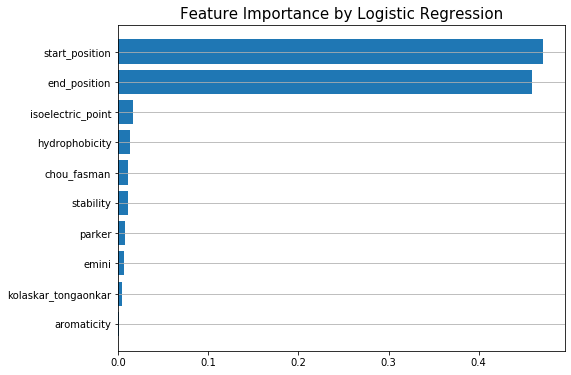

In [37]:
plt.figure(figsize=(8, 6))
plt.barh([x[0] for x in feature_import], [x[1] for x in feature_import])
plt.title('Feature Importance by Logistic Regression',Fontsize=15)
plt.grid(axis='y')

## Modeling: Random Forest 

In [12]:
# model with default parameters
model = RandomForestClassifier(random_state = SEED)
train_model(model)

Training loss :  0.09107740258027942
Validation loss :  0.38464511593070577
Test loss :  0.42114338766069903
Train accuracy 0.999874, precision 0.999948, recall 0.999587, f1 0.999767 
Valid accuracy 0.849895, precision 0.764077, recall 0.644759, f1 0.698885 
Test  accuracy 0.851107, precision 0.779503, recall 0.635679, f1 0.700221 
Test confusion matrix: 
[[2019.28571429  146.71428571]
 [ 297.28571429  518.71428571]]


In [14]:
# Gridsearch 
model = RandomForestClassifier(random_state = SEED)
params = {'max_depth':[17, 18, 19,20]}
gcv = GridSearchCV(model, params, scoring='neg_log_loss')
gcv.fit(X_train, y_train)
print('Best parameter: ', gcv.best_params_)

Best parameter:  {'max_depth': 18}


In [11]:
model = RandomForestClassifier(max_depth=18, random_state=SEED)
train_model(model)

Training loss :  0.12070216386551061
Validation loss :  0.3511769583896269
Test loss :  0.36988480299029
Train accuracy 0.988679, precision 0.999838, recall 0.958307, f1 0.978632 
Valid accuracy 0.852075, precision 0.776575, recall 0.636695, f1 0.699243 
Test  accuracy 0.849717, precision 0.782149, recall 0.624825, f1 0.694678 
Test confusion matrix: 
[[2024.          142.        ]
 [ 306.14285714  509.85714286]]


In [30]:
# Feature importance
model = RandomForestClassifier(max_depth=18, random_state=SEED)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_import = [(feature_cols[i], abs(importances[i])) for i in range(len(feature_cols))]
feature_import = sorted(feature_import, key=lambda x:x[1])
print(feature_import)

[('kolaskar_tongaonkar', 0.07819469199507226), ('parker', 0.08452496013044604), ('chou_fasman', 0.08499849652011747), ('emini', 0.08902621982085838), ('end_position', 0.09830357886604645), ('start_position', 0.09831542821166599), ('stability', 0.10392867868782123), ('aromaticity', 0.10837875779918013), ('isoelectric_point', 0.11692126073893003), ('hydrophobicity', 0.13740792722986211)]


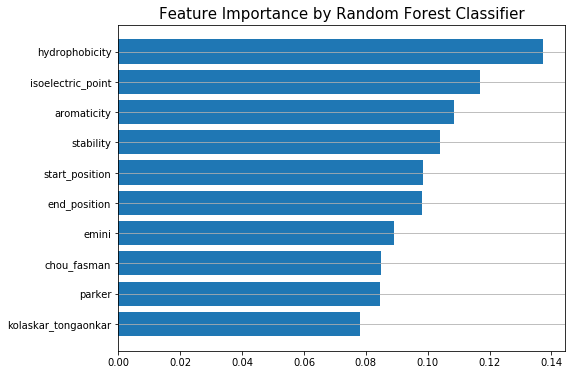

In [31]:
plt.figure(figsize=(8, 6))
plt.barh([x[0] for x in feature_import], [x[1] for x in feature_import])
plt.title('Feature Importance by Random Forest Classifier',Fontsize=15)
plt.grid(axis='y')

## Gradient Boosting

In [ ]:
# model with default parameters
model = XGBClassifier(random_state=SEED)
train_model(model)

In [39]:
# Gridsearch 
model = XGBClassifier(random_state = SEED)
params = {'max_depth':[4,5,6,7,8]}
gcv = GridSearchCV(model, params, scoring='neg_log_loss')
gcv.fit(X_train, y_train)
print('Best parameter: ', gcv.best_params_)

Best parameter:  {'max_depth': 6}


In [15]:
model = XGBClassifier(max_depth=6, random_state=SEED)
train_model(model)

Training loss :  0.17777053012456934
Validation loss :  0.3743147875577157
Test loss :  0.38656826640974096
Train accuracy 0.949965, precision 0.956532, recall 0.853844, f1 0.902272 
Valid accuracy 0.838826, precision 0.751070, recall 0.605397, f1 0.669872 
Test  accuracy 0.836878, precision 0.759870, recall 0.590511, f1 0.664550 
Test confusion matrix: 
[[2013.71428571  152.28571429]
 [ 334.14285714  481.85714286]]
